# Cutler Poster Reproduction

## Dependencies

In [1]:
import pandas as pd
import numpy as np
import json
from psifr import fr

# load collection of similarity matrices and convert to numpy
with open('../data/similarities.json', 'r') as f:
    connections = json.load(f)
for key in connections.keys():
    connections[key] = np.array(connections[key])

# load recall data frame
data = pd.read_csv('../data/psifr_sbs.csv')
events = fr.merge_free_recall(
    data, list_keys=['item_index', 'cycle', 'story_index', 
                     'story_name', 'time_test'])
events.head()

,subject,list,item,input,output,study,recall,repeat,intrusion,item_index,cycle,story_index,story_name,time_test
0,0,0,One fine day an old Maine man was fishing,1.0,NaN,True,False,0,False,0,0,0,Fisherman,1
1,0,0,on his favorite lake,2.0,2.0,True,True,0,False,1,0,0,Fisherman,1
2,0,0,and catching very little,3.0,NaN,True,False,0,False,2,0,0,Fisherman,1
3,0,0,"Finally, he gave up",4.0,3.0,True,True,0,False,3,1,0,Fisherman,1
4,0,0,and walked back along the shore to his fishing...,5.0,NaN,True,False,0,False,4,1,0,Fisherman,1


## Recall Rates
Her first figure compared recall rates between immediate and delayed recall conditions, plotting a unique point for each subject in the dataset. 

In [2]:
recall_rates_by_timetest = events.pivot_table(
    index=['subject', 'time_test'], values='recall').reset_index()
recall_rates_by_timetest.head()

,subject,time_test,recall
0,0,1,0.427350
1,0,2,0.564103
2,0,3,0.380952
3,1,1,0.735043
4,1,2,0.880342


I have to figure out which timeTest columns she used for each condition. My hypothesis based on her methodology panel is that she used the second column for her 'immediate' condition and the third column for her 'delayed' condition.

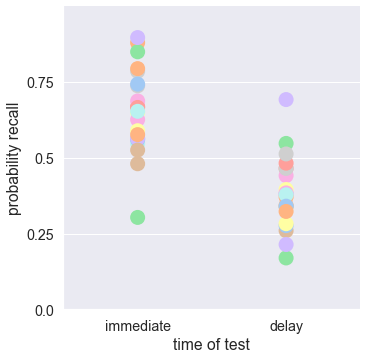

In [89]:
import seaborn as sns

sns.set_theme(font_scale=1.3, style='darkgrid')

sns.catplot(
    x='time_test', y="recall", 
    data=recall_rates_by_timetest.loc[recall_rates_by_timetest.time_test > 1], 
        jitter=False, s=15, hue='subject', legend=False, palette='pastel');
plt.xticks(np.arange(2), ['immediate', 'delay'])
plt.yticks(np.arange(0, 1, .25), np.arange(0, 1, .25))
plt.xlabel('time of test')
plt.ylabel('probability recall')
plt.ylim([0, 1])
plt.show()

My hypothesis seems correct.

## Serial Position Curve
She rescaled the data as percentiles to enable generalization over story length. I suspect this was a bad idea. I'll focus on producing this plot per story. 

In [52]:
spc = events.query('study').pivot_table(
    index=['subject', 'story_name', 'time_test', 'input'], values=['recall']).reset_index()
spc.reset_index(level=0, inplace=True)
spc = spc.loc[spc.time_test > 1]
spc.head()

,index,subject,story_name,time_test,input,recall
40,40,0,Beach,2,1.0,True
41,41,0,Beach,2,2.0,True
42,42,0,Beach,2,3.0,True
43,43,0,Beach,2,4.0,True
44,44,0,Beach,2,5.0,False


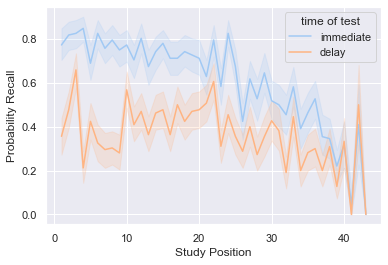

In [104]:
#sns.set_theme(font_scale=1, style="dark")
#g = sns.FacetGrid(spc, col='story_name', row='time_test')
#g.map_dataframe(sns.lineplot, 'input', 'recall');

#sns.lineplot(x=np.arange(len(connection_strengths[story_name])), y=connection_strengths[story_name]);
sns.set(style='darkgrid')
g = sns.lineplot(data=spc, x='input', y='recall', hue='time_test', palette='pastel')
plt.xlabel('Study Position')
plt.ylabel('Probability Recall')
plt.legend(['immediate', 'delay'], title='time of test');

We _do_ find a steady decline in performance across serial position at immediate test, but not at delayed test.

## Temporal Contiguity
She compared lag-CRPs for the immediate and delayed conditions, across stories and subjects. We'll aggregate outputs from the `fr.lag_crp` function in `psifr`.

In [6]:
lag_crps = []
for time_test in pd.unique(events.time_test):
    lag_crps.append(fr.lag_crp(events[events.time_test == time_test]))
    
clean = pd.concat(
    lag_crps, keys=pd.unique(events.time_test), names=['time_test']).reset_index()

clean = clean.loc[clean.time_test > 1]
clean.head()

,time_test,subject,lag,prob,actual,possible
1870,2,0,-42.0,NaN,0,0
1871,2,0,-41.0,NaN,0,0
1872,2,0,-40.0,NaN,0,0
1873,2,0,-39.0,NaN,0,0
1874,2,0,-38.0,NaN,0,0


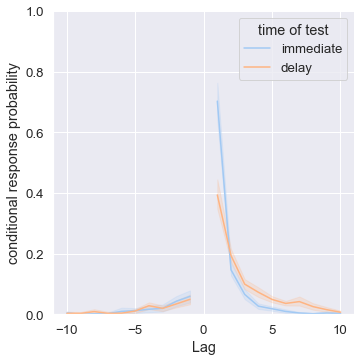

In [106]:
import matplotlib.pyplot as plt
sns.set_theme(font_scale=1.2, style="darkgrid")

max_lag = 10
filt_neg = f'{-max_lag} <= lag < 0'
filt_pos = f'0 < lag <= {max_lag}'

g = sns.FacetGrid(clean, height=5)
g.map_dataframe(
    lambda data, **kws: sns.lineplot(
        data=data.query(filt_neg), x='lag', y='prob', hue='time_test', palette='pastel', **kws)
)
g.map_dataframe(
    lambda data, **kws: sns.lineplot(
        data=data.query(filt_pos), x='lag', y='prob', hue='time_test', palette='pastel', **kws)
)
g.set_xlabels('Lag')
g.set_ylabels('conditional response probability')
plt.legend(['immediate', 'delay'], title='time of test')
g.set(ylim=(0, 1));

## Semantic Organization

### Representational Similarity Matrix
First we need to apply a similarity metric close enough to that of the Cutler poster to reproduce the representational similarity matrices she visualized. She reports that she used the GloVe semantic vector space model and focused analysis on "content words", presumably excluding stop words as tracked in packages like `nltk` and `spacy`.

In [8]:
units = events.pivot_table(index=['story_name', 'input'], values='item', aggfunc='first').reset_index()
units.head()

,story_name,input,item
0,Beach,1.0,"It was a hot, sunny day"
1,Beach,2.0,and Kaylie and Rachel
2,Beach,3.0,decided to take advantage of their off day
3,Beach,4.0,and take a trip to the beach.
4,Beach,5.0,"The sun was an optimistic yellow pellet,"


In [120]:
from sentence_transformers import SentenceTransformer, util
import spacy

nlp = spacy.load('en_core_web_sm')
all_stopwords = nlp.Defaults.stop_words

# paraphrase-MiniLM-L12-v2
# average_word_embeddings_glove.6B.300d
# stsb-distilbert-base
model = SentenceTransformer('average_word_embeddings_glove.6B.300d') 
connections = {}
remove_stopwords = False

for story_name in ['Fisherman', 'Supermarket', 'Flight', 'Cat', 'Fog', 'Beach']:
    
    sentences = units.loc[units.story_name==story_name].item.values.tolist()
    
    clean_sentences = []
    for i in range(len(sentences)):
        if remove_stopwords:
            text_token = nlp(sentences[i])
            clean_sentences.append(' '.join([word.text for word in text_token if not word.is_stop]))
        else:
            clean_sentences.append(sentences[i])
    
    #Compute embeddings
    embeddings = model.encode(clean_sentences, convert_to_tensor=True)

    #Compute cosine-similarities for each sentence with each other sentence
    cosine_scores = np.abs(util.pytorch_cos_sim(embeddings, embeddings).numpy())
    cosine_scores[np.eye(len(cosine_scores), dtype='bool')] = np.nan
    connections[story_name] = cosine_scores

# Let's take a peek at the ranges of these similarity scores.
# Technically, they should never be below 0, but norming is always an option.
for story_name in connections.keys():
    print(story_name)
    print(np.nanmax(connections[story_name]), np.nanmin(connections[story_name]))

Fisherman
0.8858701 0.020831604
Supermarket
0.79936534 0.003664568
Flight
0.7510009 1.720339e-05
Cat
0.8562583 0.0
Fog
0.8610011 0.0042896834
Beach
0.7738054 0.001596339


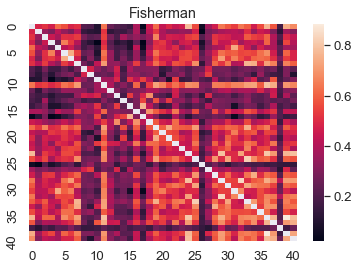

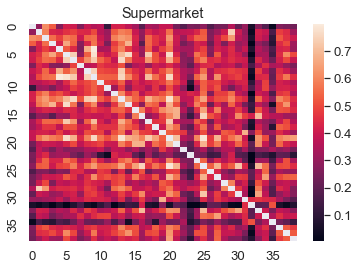

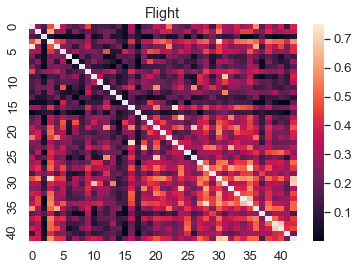

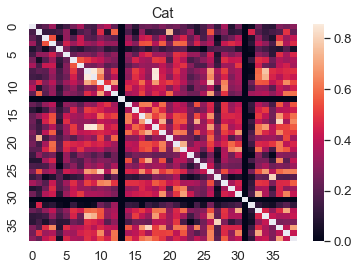

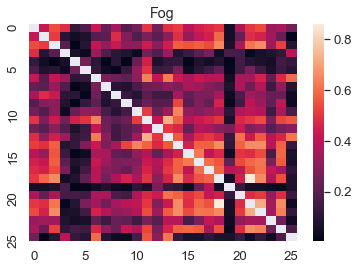

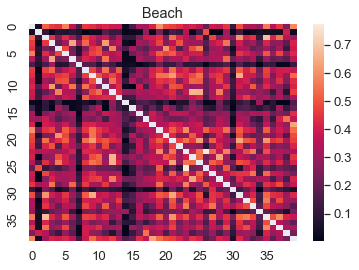

In [121]:
for story_name in connections.keys():
    
    sns.heatmap(connections[story_name], xticklabels=5, yticklabels=5)
    plt.title(story_name)
    plt.show()

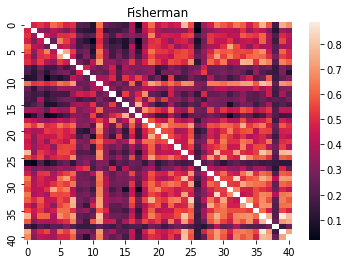

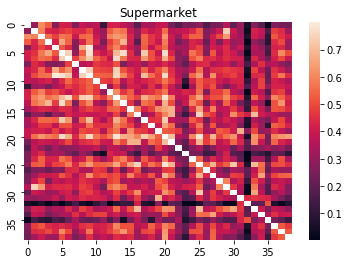

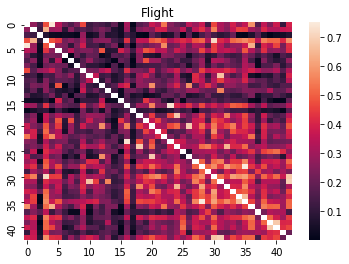

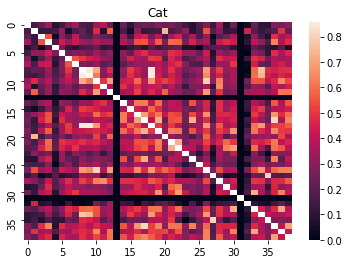

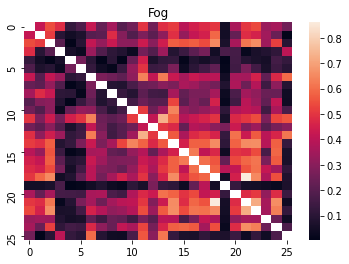

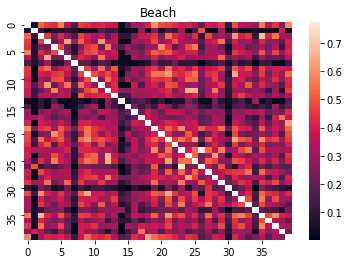

In [10]:
for story_name in connections.keys():
    sns.heatmap(connections[story_name], 
            xticklabels=5, yticklabels=5);
    plt.title(story_name)
    plt.show()

### Recall benefit for idea units that are more semantically similar to other idea units in the narrative
It looks like for each idea unit across all stories, I need either a mean or summed similarity to every other relevant idea unit, along with its mean recall probability across subjects, split between time_test values. Plot the result and a line of best fit. Should see a nonsignificant positive relationship in the delayed condition but not the immediate.

Fisherman
0.8858701 0.020831604
Supermarket
0.79936534 0.003664568
Flight
0.7510009 1.720339e-05
Cat
0.8562583 0.0
Fog
0.8610011 0.0042896834
Beach
0.7738054 0.001596339


### Analysis

In [13]:
strengths_df = 

strengths_df['cosine similarity'] = connection_strength_column

sns.lmplot(data=clean, x="cosine similarity", y="recall", palette="deep", hue='time_test');

KeyError: "['recall', 'cosine similarity'] not in index"

## Semantic CRP
This wasn't in the original poster, but is a natural extension: 

In [ ]:
edges = [0.5299, 0.5799, 0.6299, 0.6799, 0.7299, 0.7799, 0.8299, 0.8799, 0.9299, 0.9799]
centers = [0.5620, 0.6102, 0.6593, 0.7073, 0.7552, 0.8032, 0.8516, 0.9023, 0.9440]

for story_name in passage_names:
    
    dcrp = fr.distance_crp(events[events.story_name==story_name], 'item_index', 
                    1-np.array(similarity_result[story_name]), edges, centers)
    g = fr.plot_distance_crp(dcrp, min_samples=5)
    g.set(xlim=(.5, 1), ylim=(0, .2));

    plt.show()
